<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_etc_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

0      1         2   ...                          10         11      12
0      Date  State  Positive  ...  On Ventilator – Cumulative  Recovered  Deaths
1  20200427     AK       345  ...                                    218       9
2  20200427     AL     6,499  ...                         195                222
3  20200427     AR     3,017  ...                                    987      50
4  20200427     AS         0  ...                                              0

[5 rows x 13 columns]

In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MA', 'IL', 'CA', 'PA', 'MI', 'FL', 'LA', 'TX', 'CT',
       'GA', 'MD', 'IN', 'OH', 'VA', 'WA', 'CO', 'TN', 'NC', 'RI', 'MO',
       'AZ', 'AL', 'MS', 'WI', 'IA', 'SC', 'NV', 'UT', 'DE', 'KY', 'DC',
       'MN', 'KS', 'OK', 'NE', 'AR', 'NM', 'OR', 'SD', 'ID', 'NH', 'PR',
       'WV', 'ME'], dtype=object)

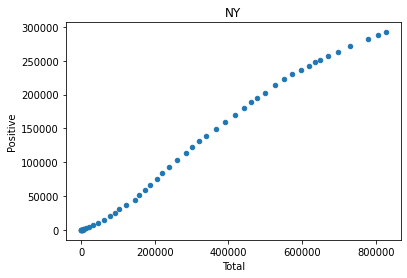

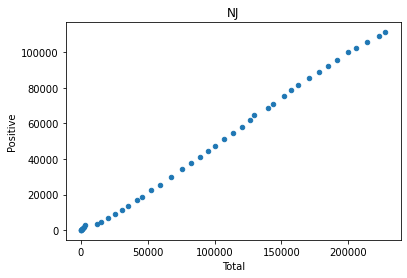

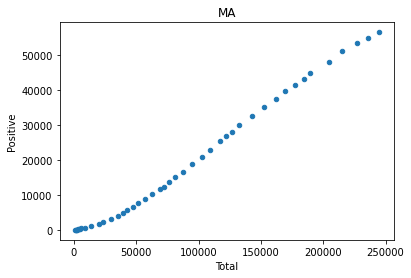

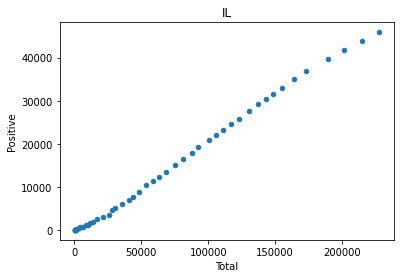

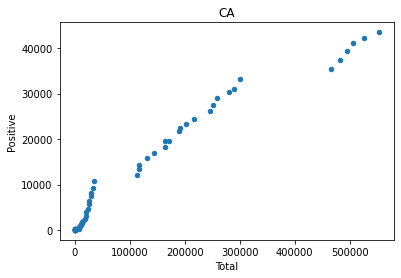

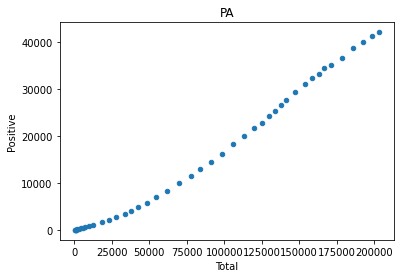

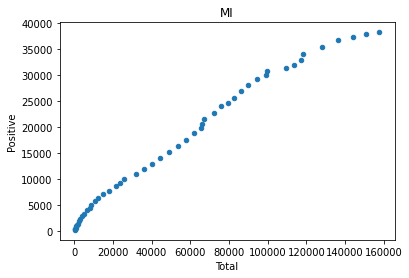

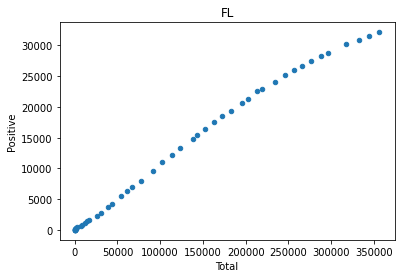

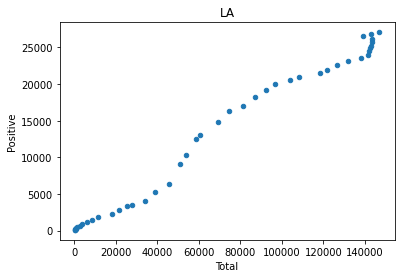

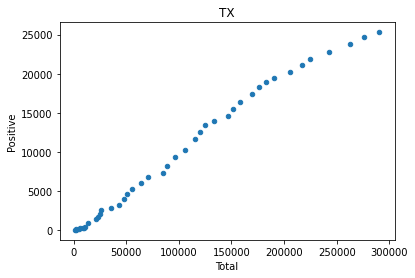

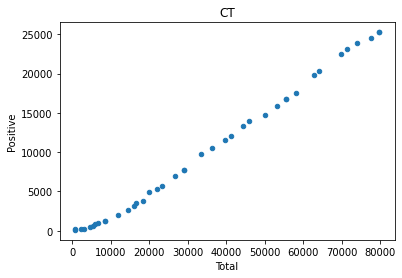

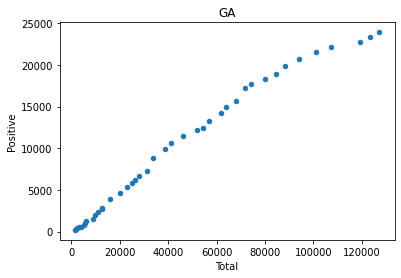

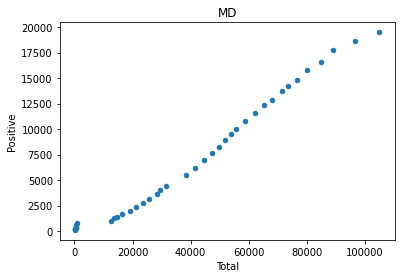

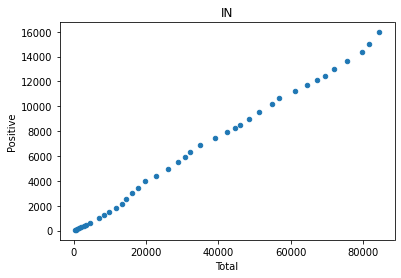

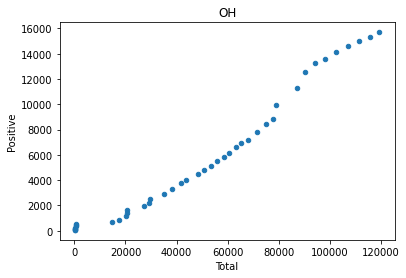

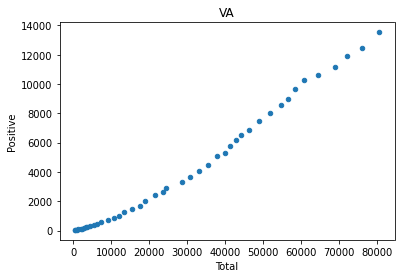

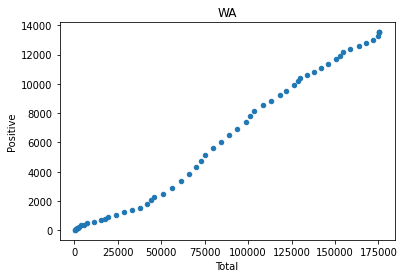

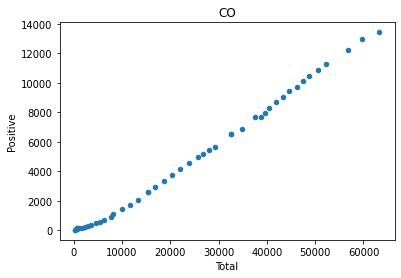

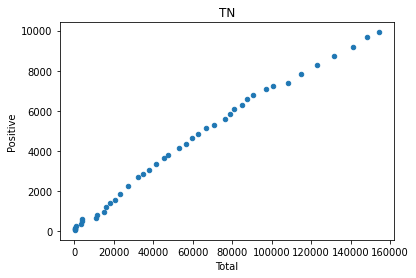

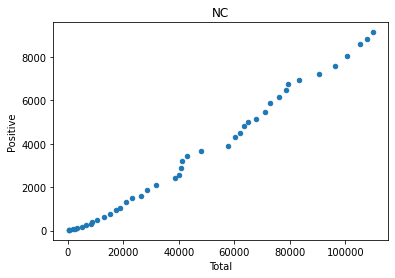

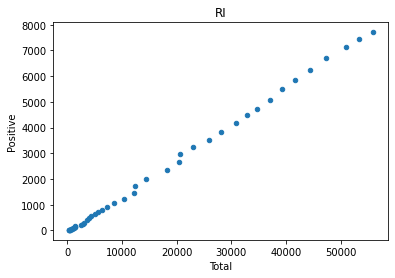

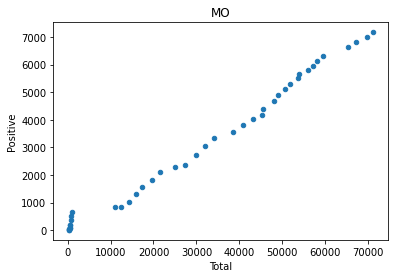

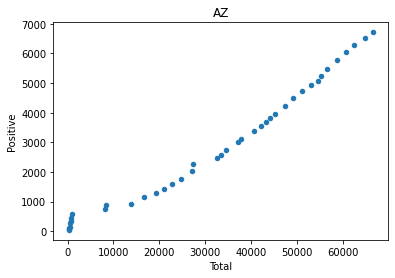

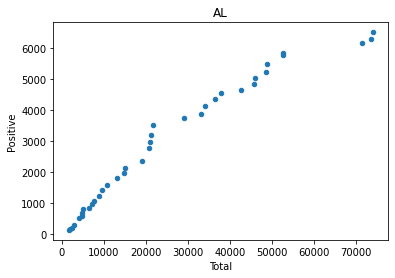

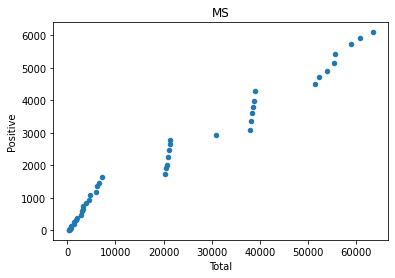

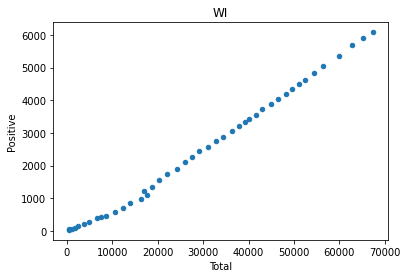

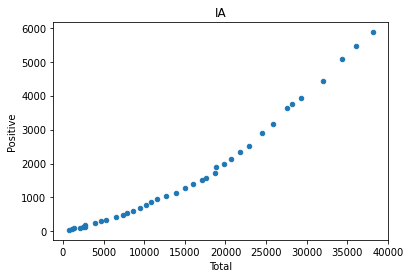

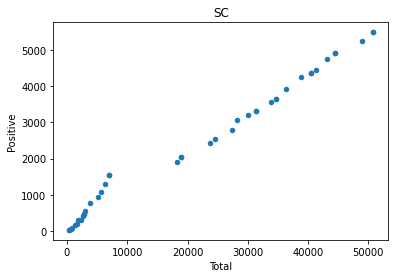

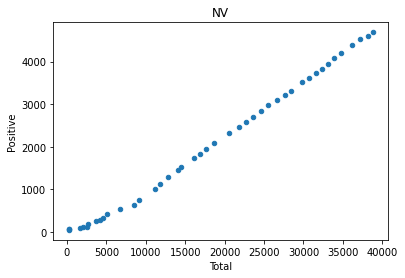

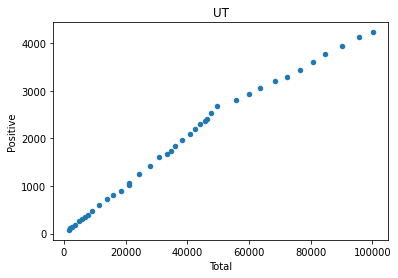

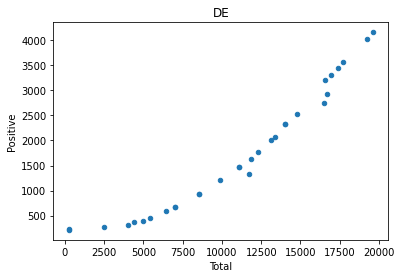

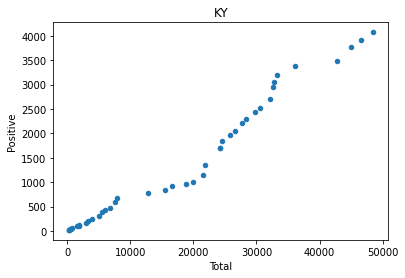

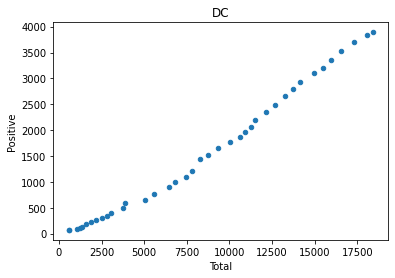

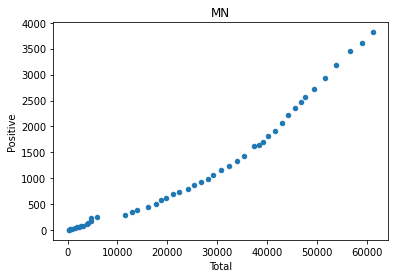

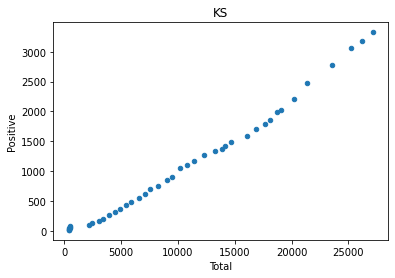

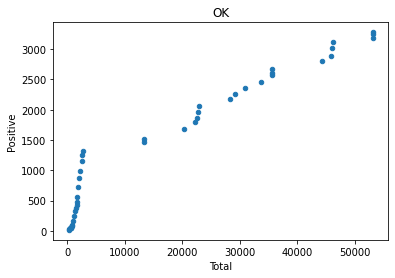

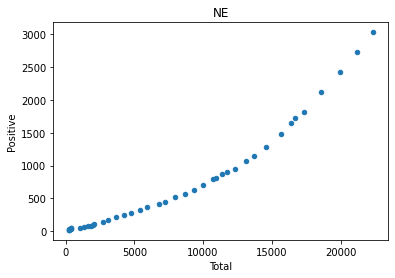

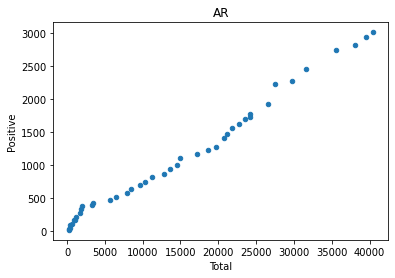

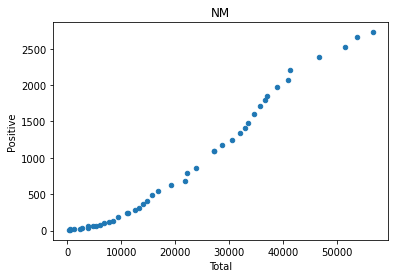

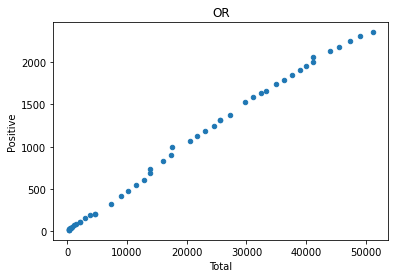

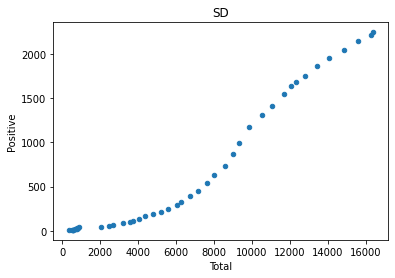

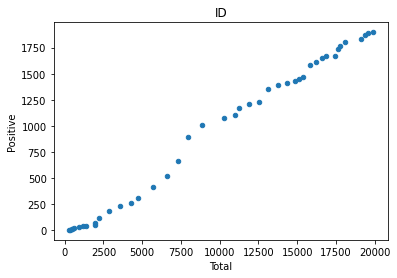

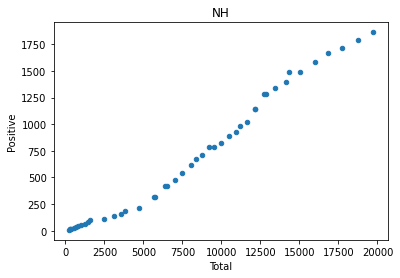

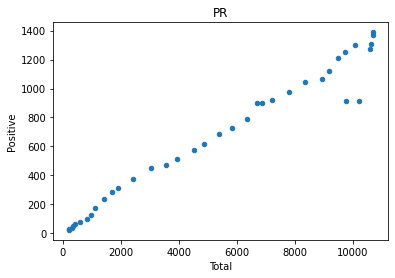

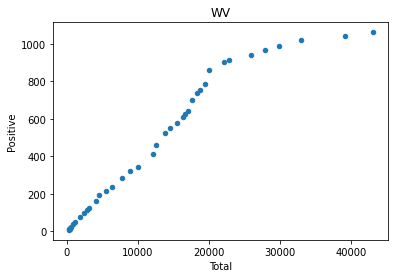

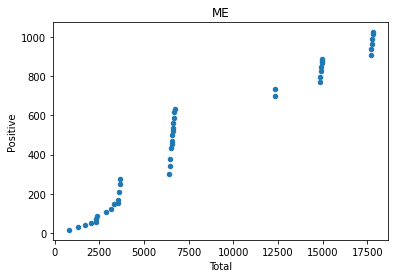

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

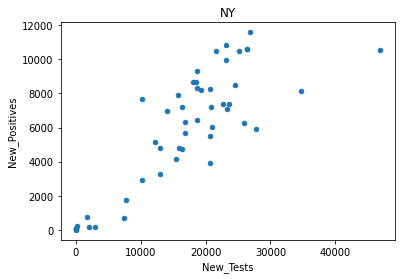

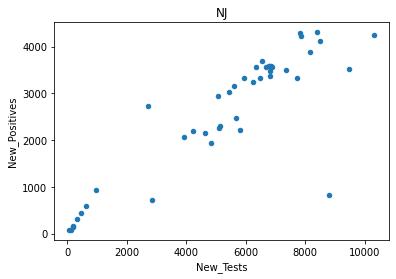

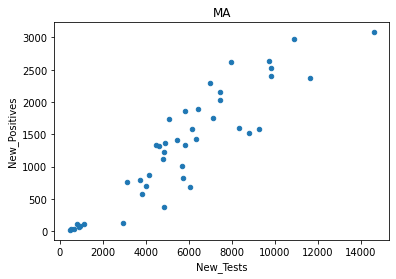

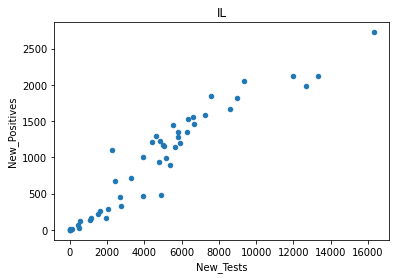

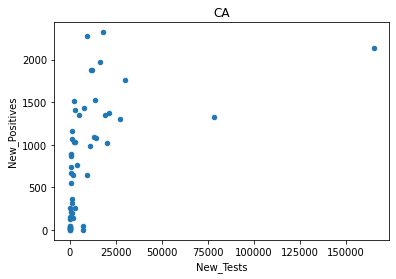

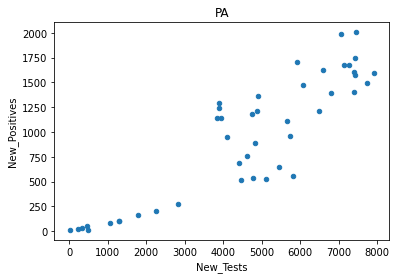

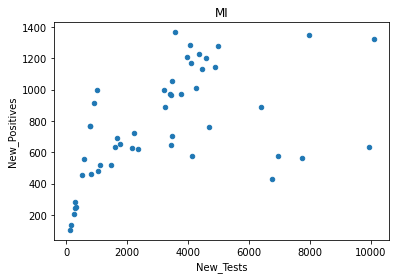

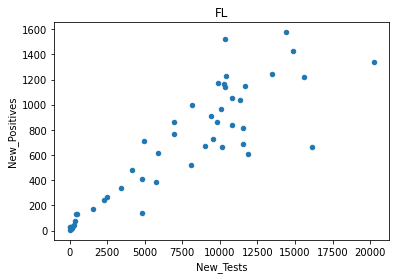

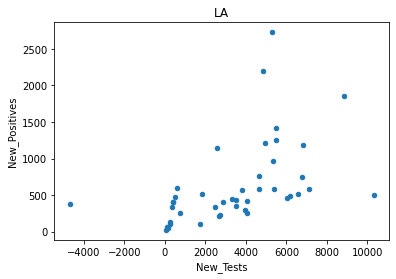

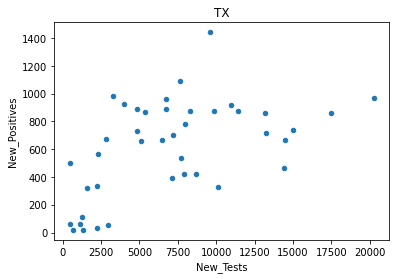

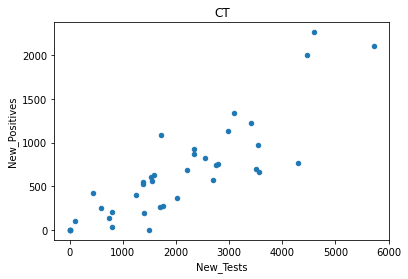

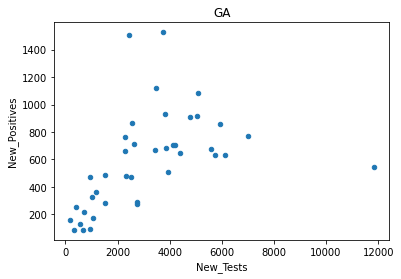

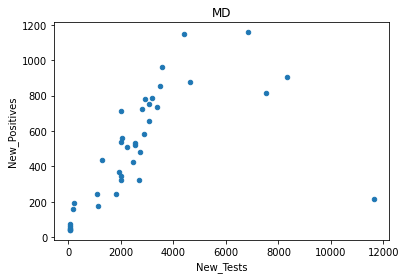

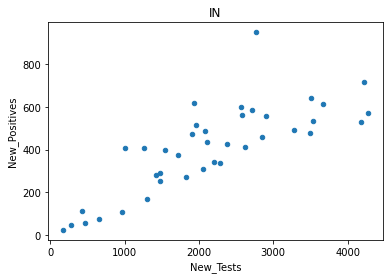

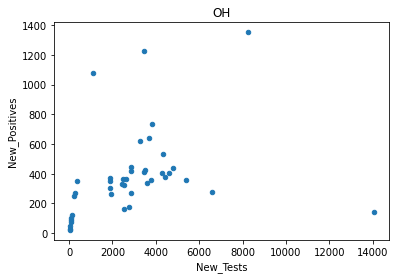

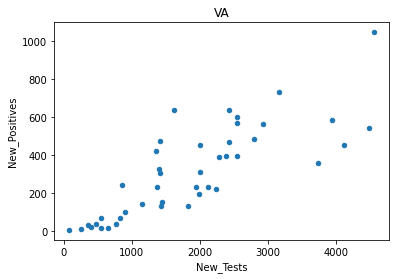

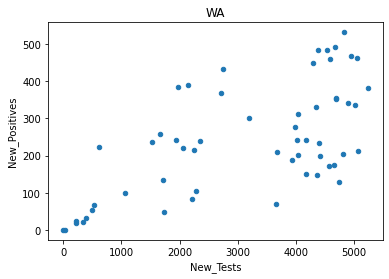

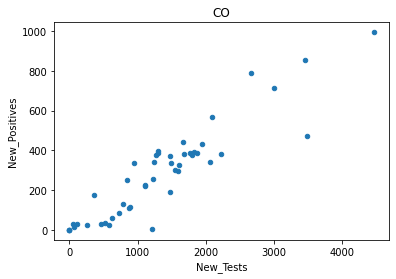

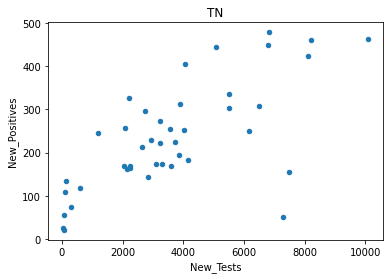

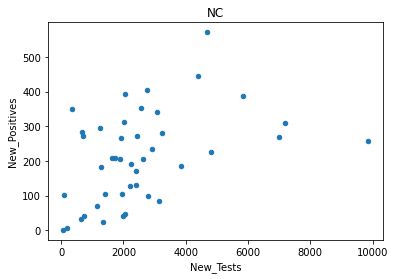

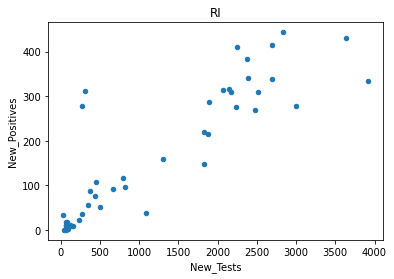

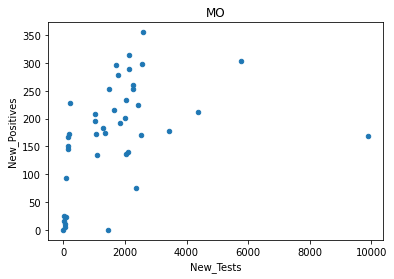

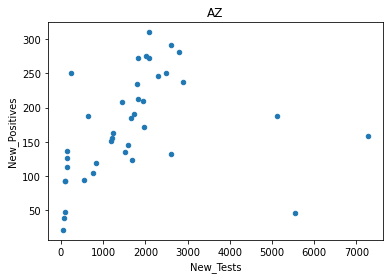

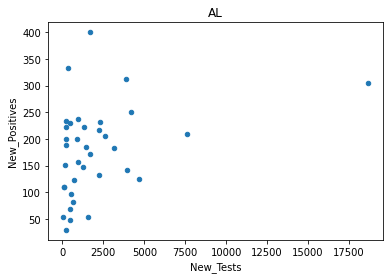

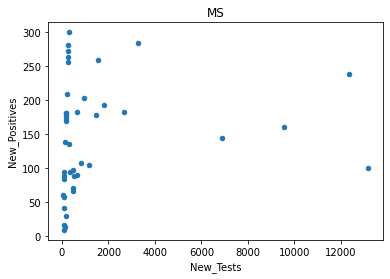

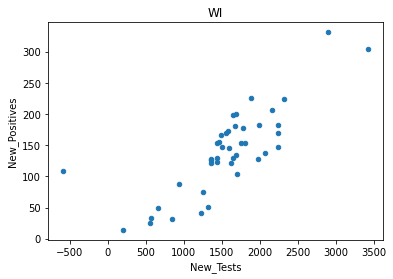

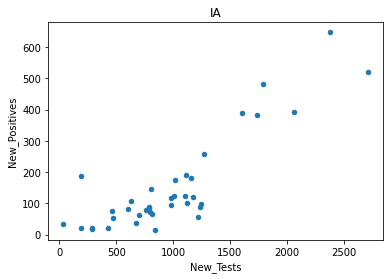

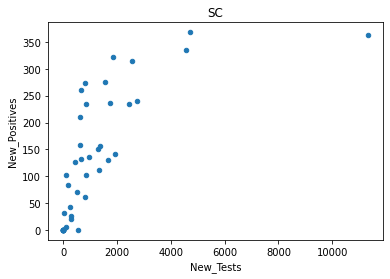

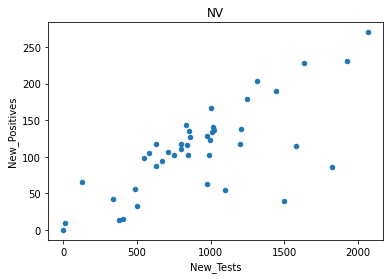

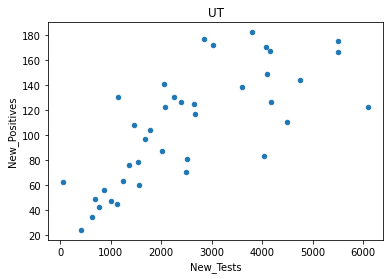

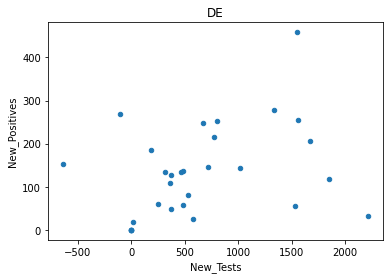

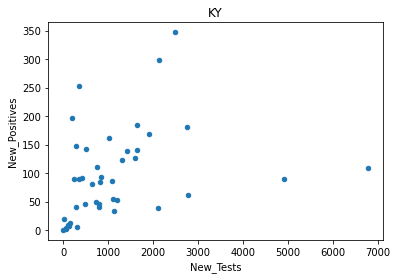

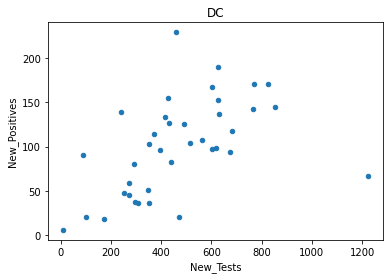

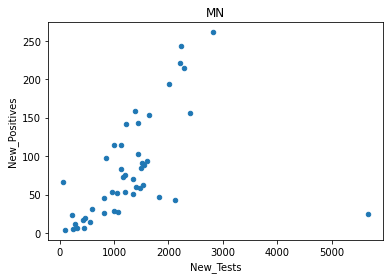

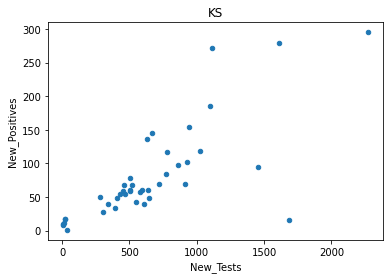

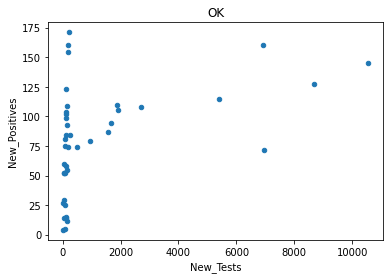

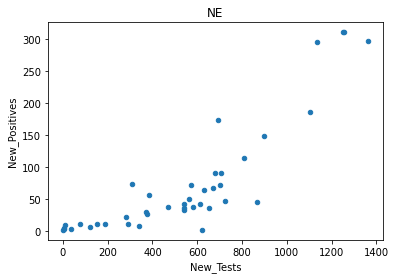

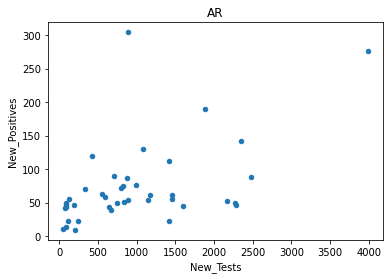

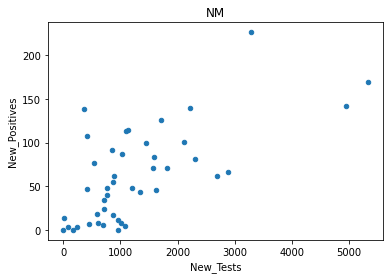

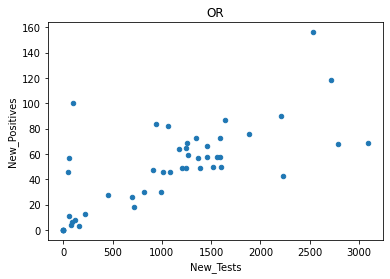

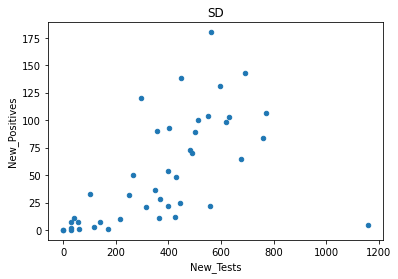

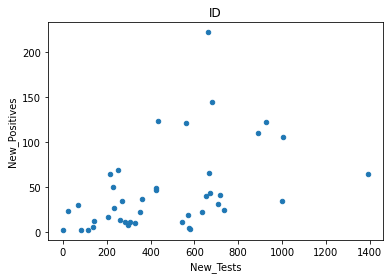

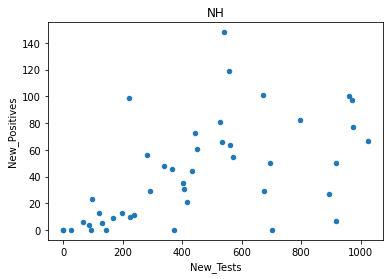

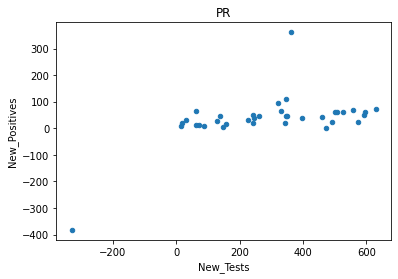

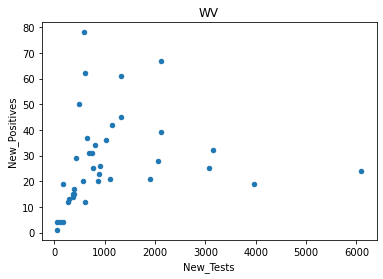

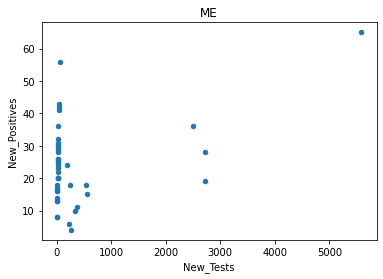

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

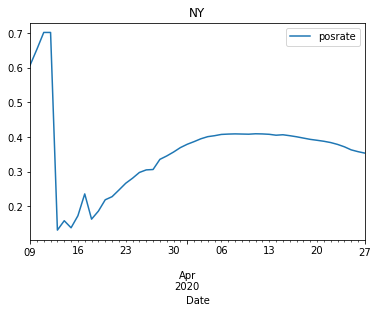

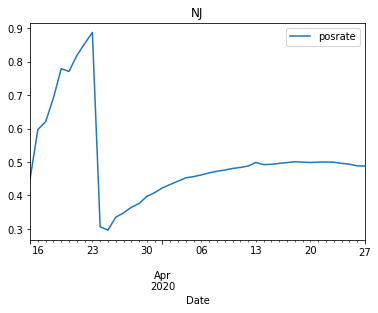

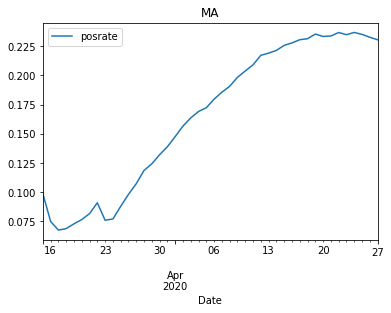

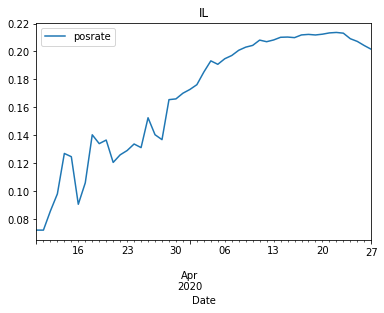

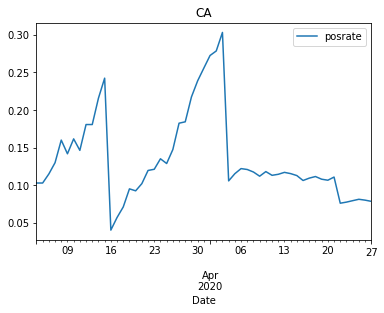

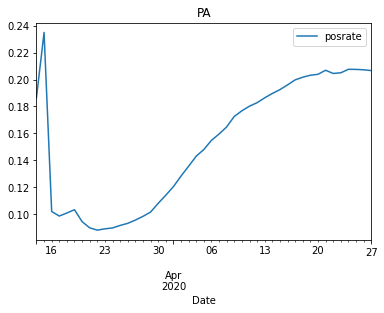

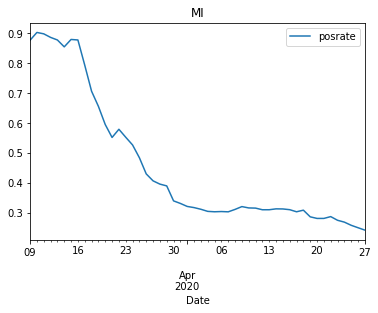

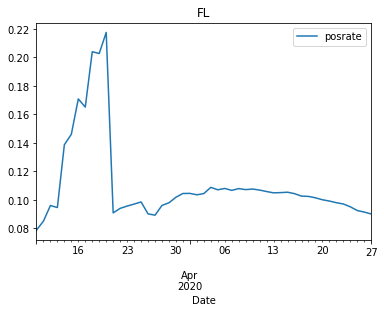

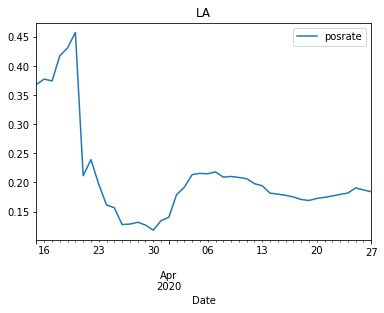

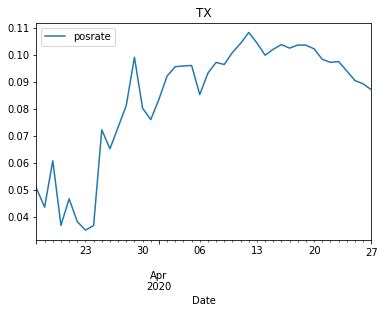

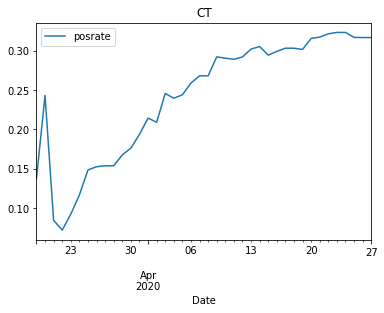

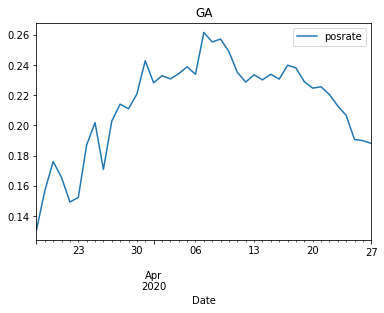

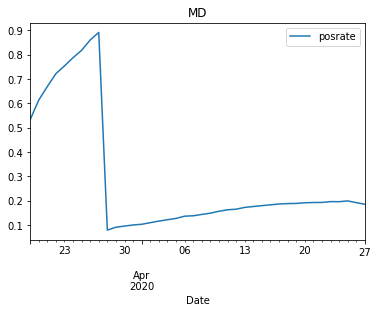

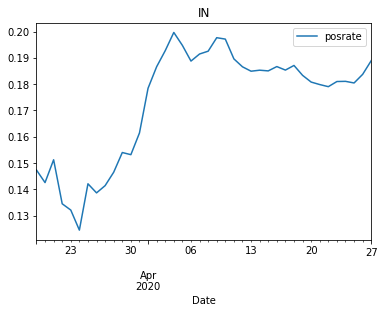

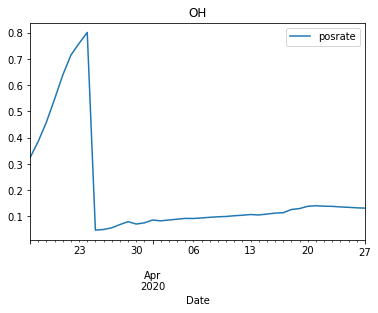

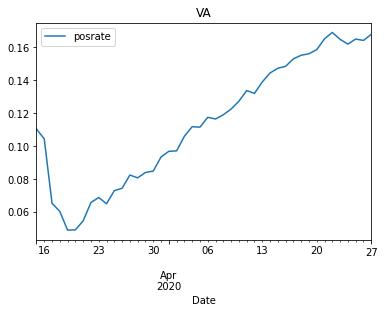

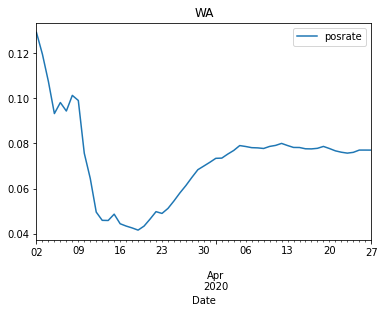

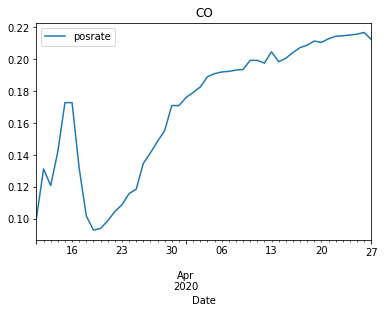

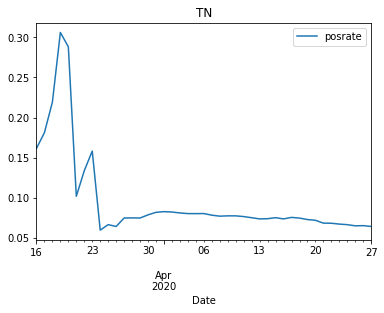

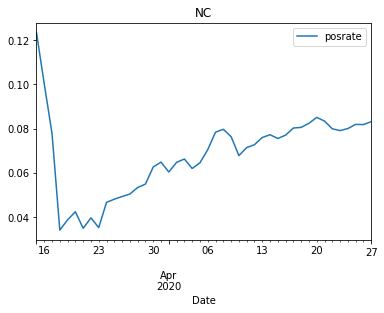

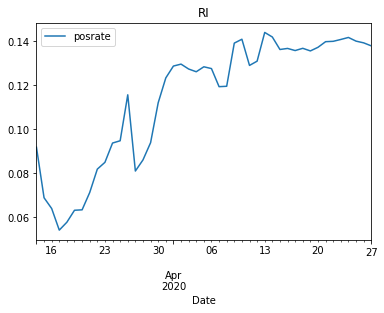

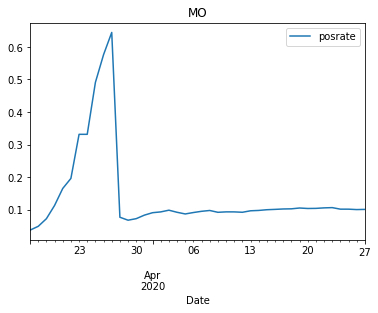

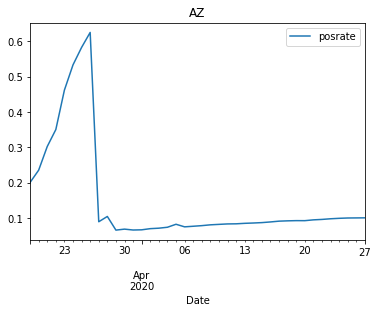

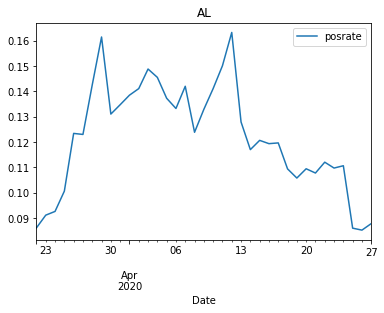

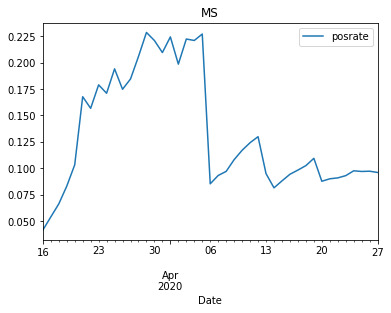

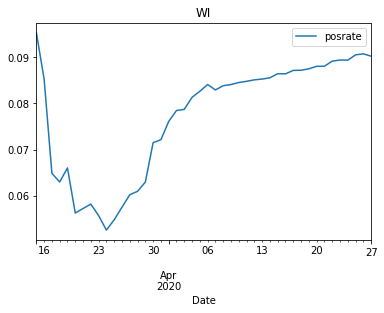

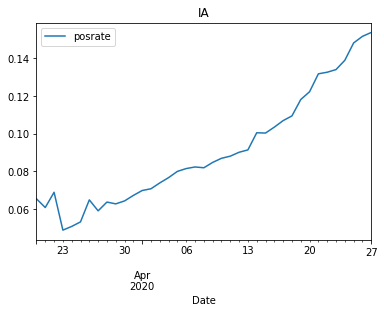

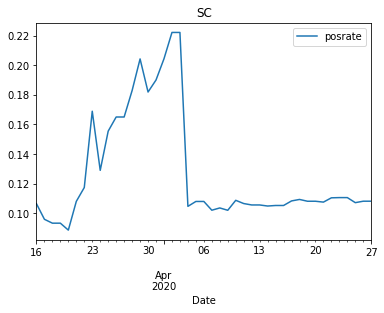

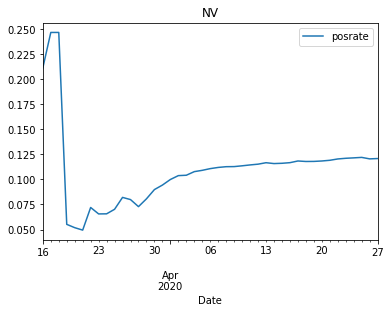

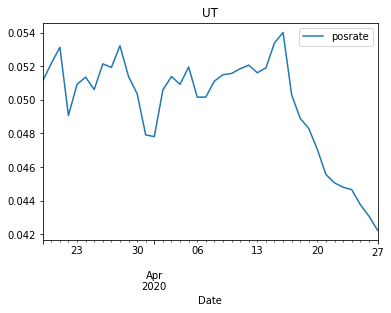

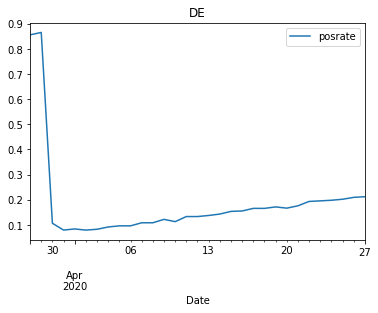

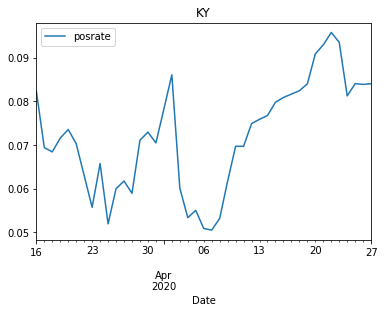

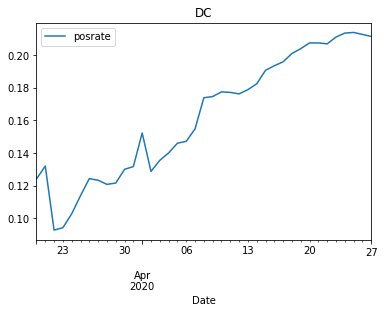

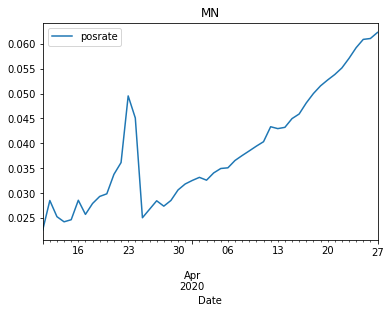

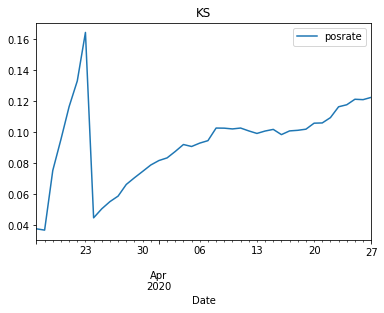

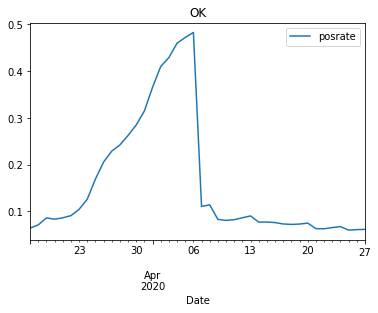

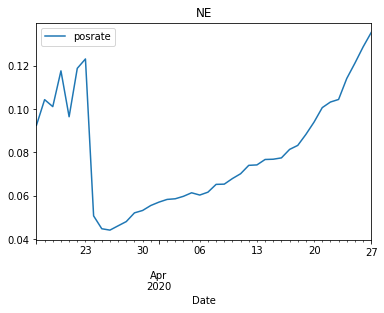

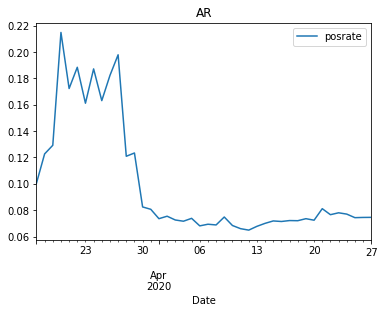

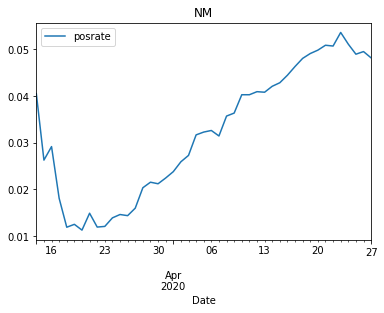

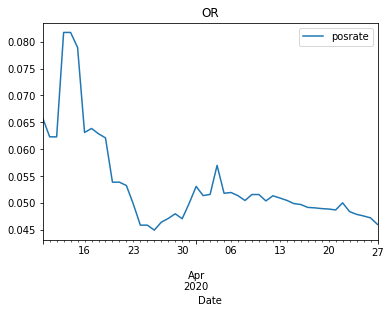

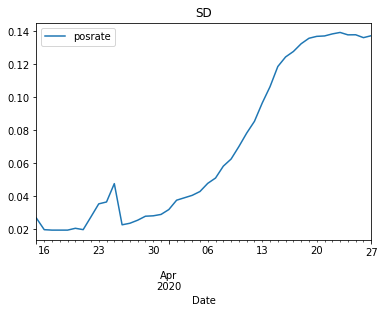

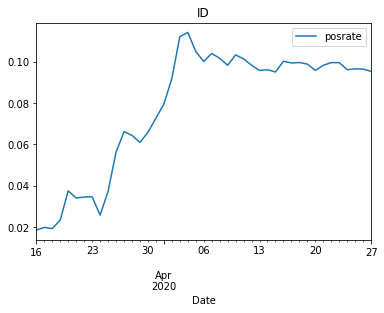

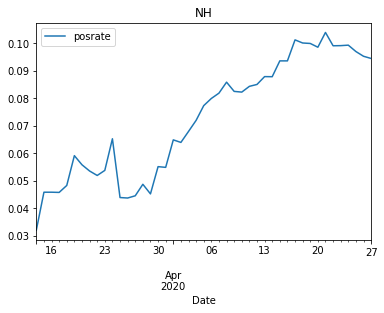

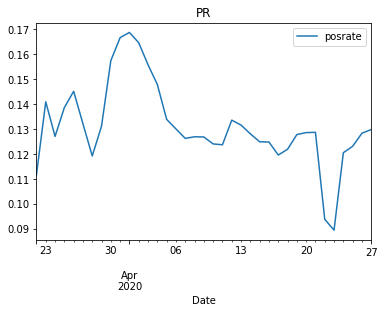

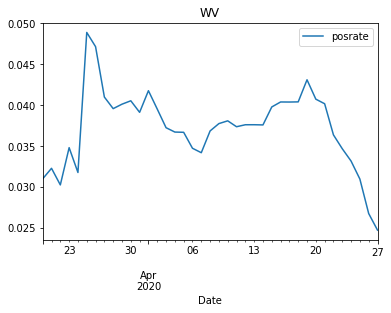

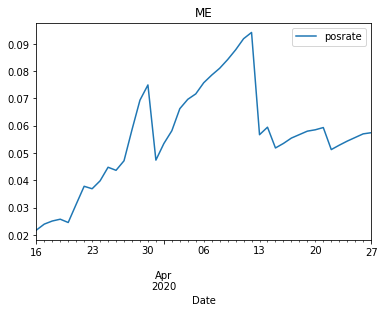

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

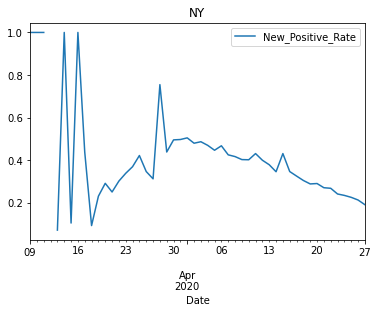

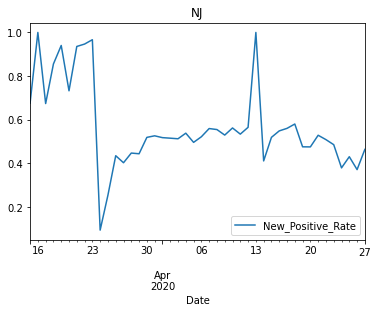

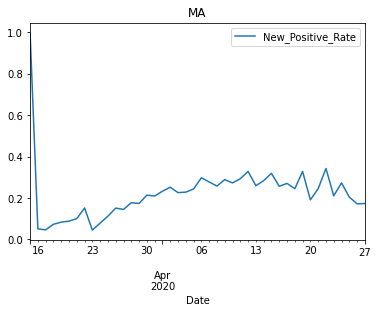

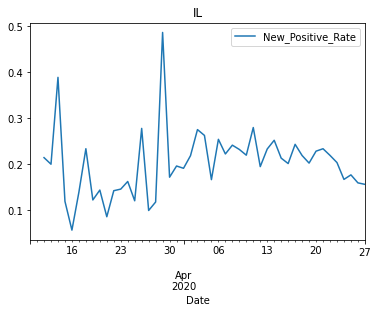

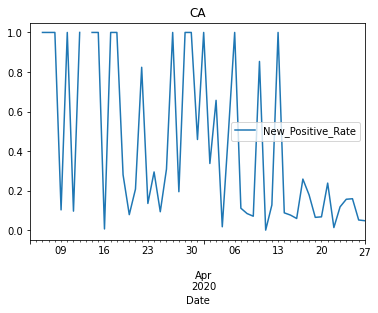

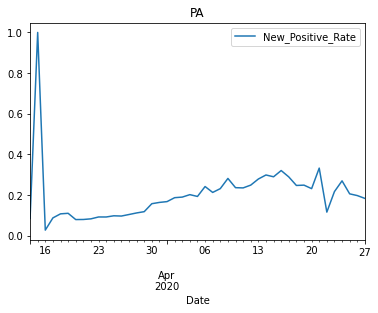

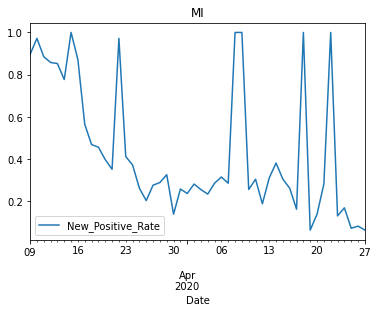

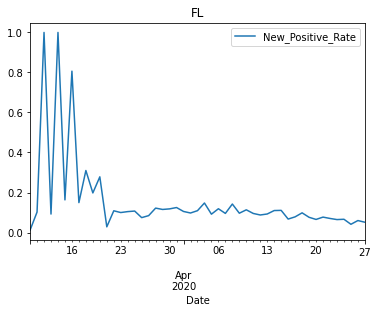

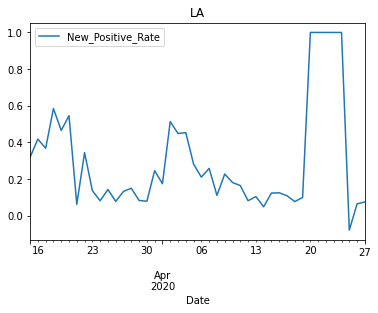

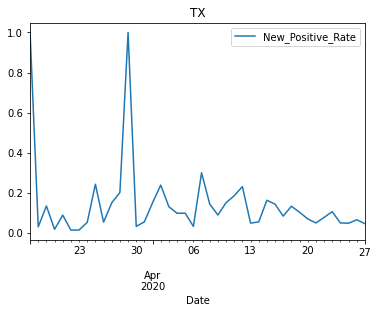

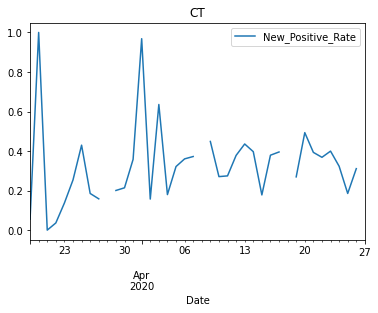

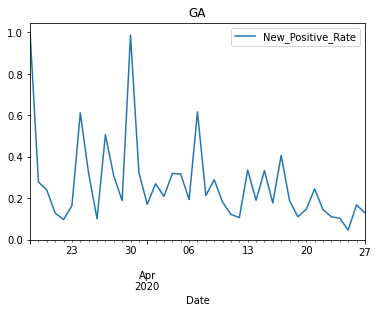

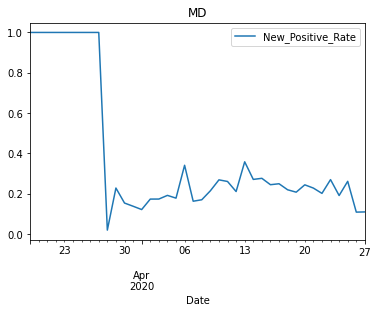

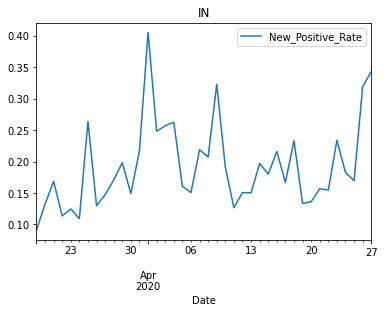

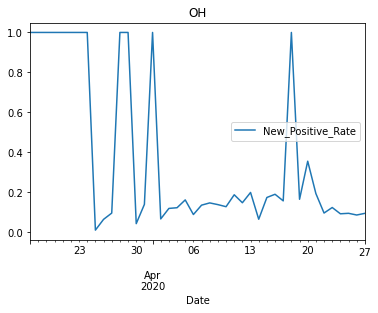

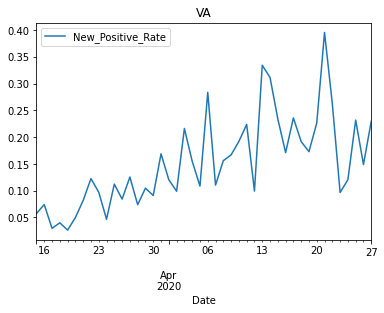

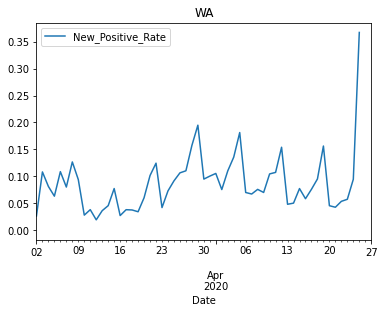

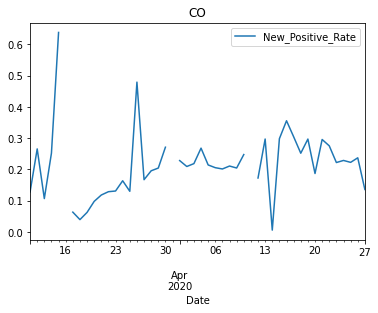

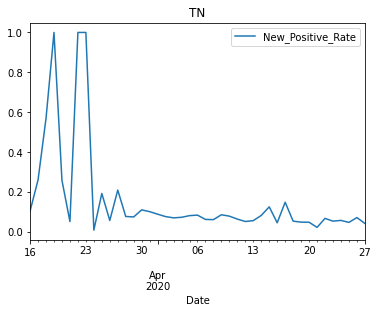

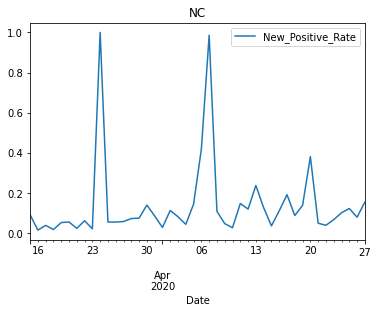

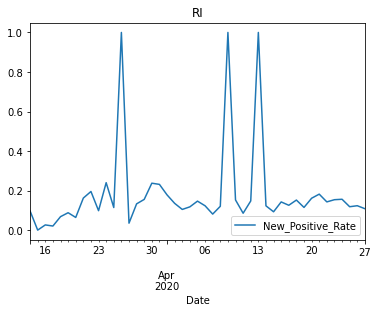

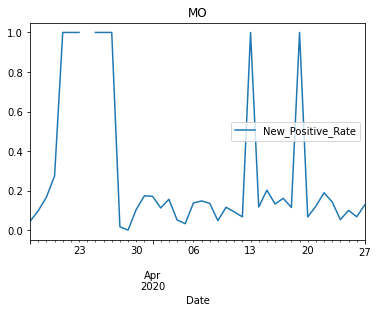

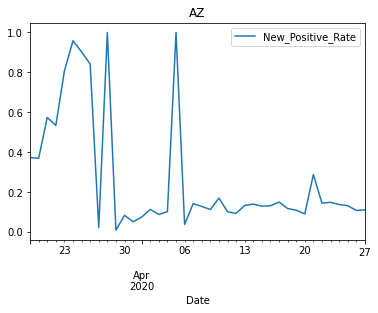

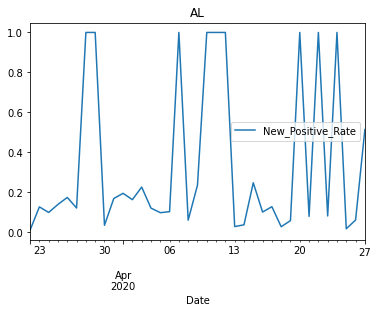

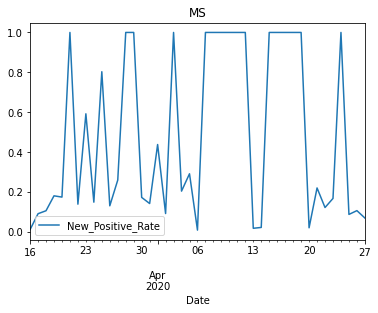

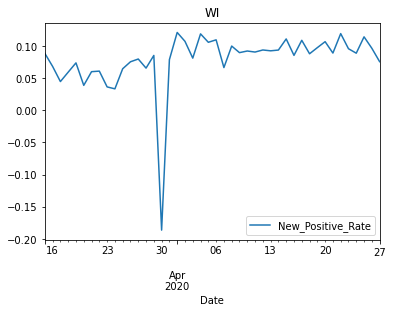

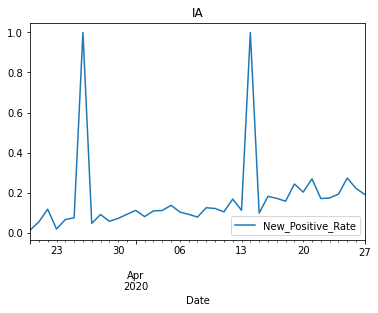

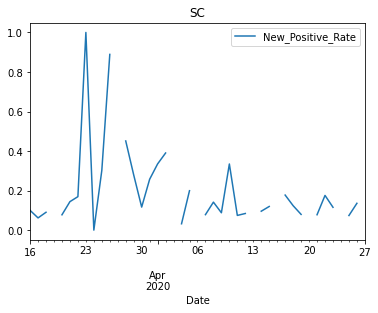

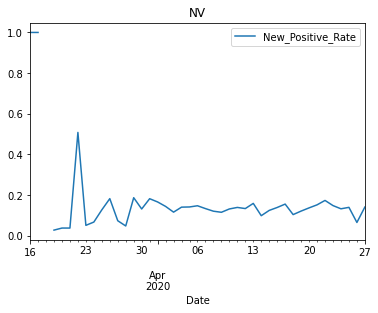

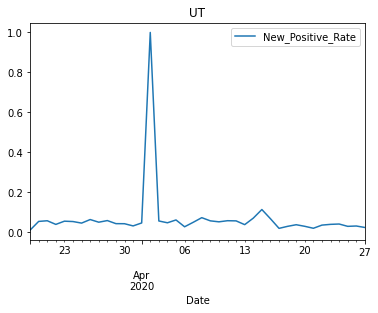

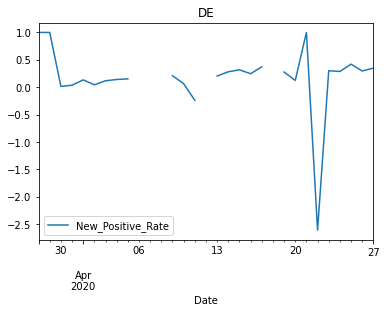

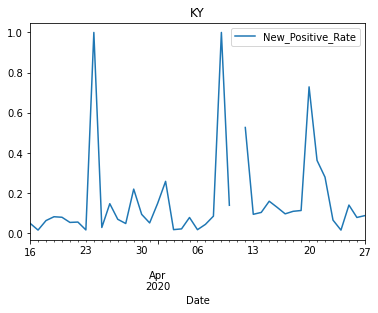

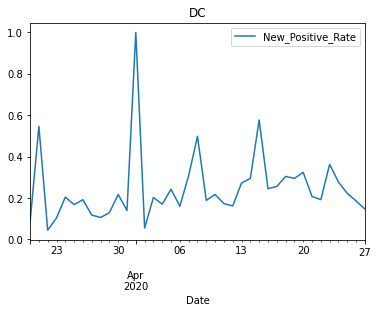

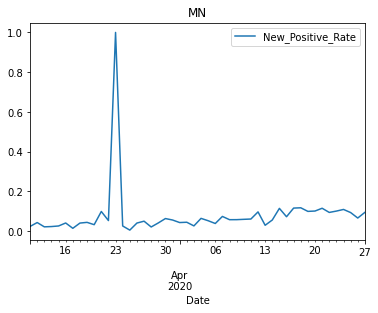

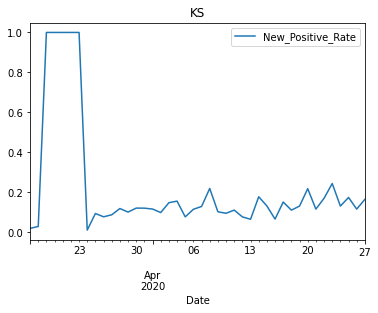

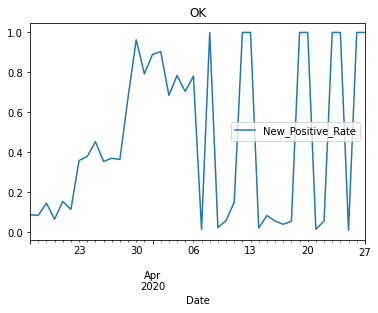

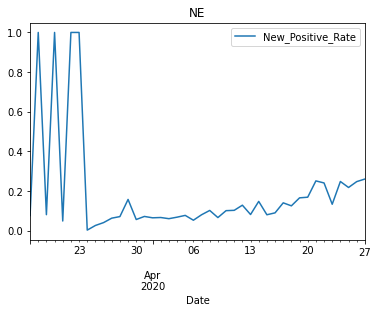

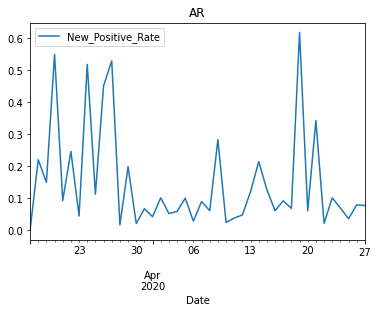

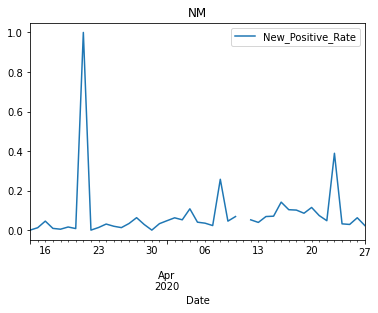

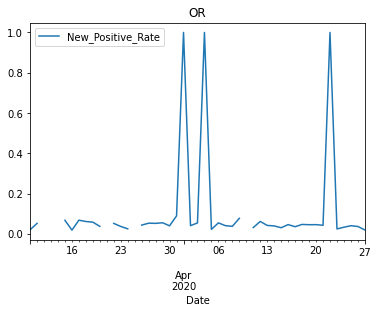

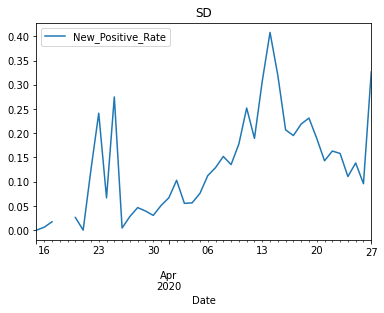

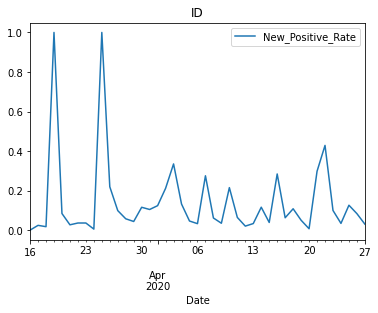

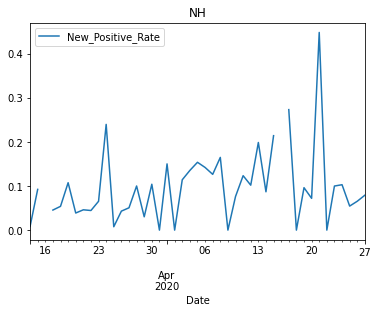

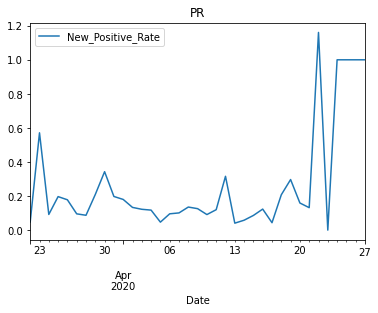

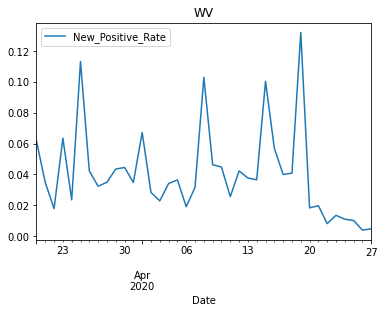

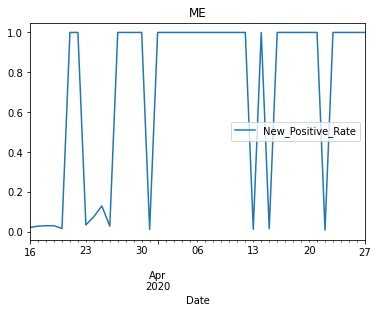

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
OR     0.050719  0.004246
WV     0.035068  0.009207
MN     0.040526  0.011026
KY     0.071812  0.012585
WI     0.076706  0.012734
WA     0.069176  0.012832
NM     0.032182  0.014346
NC     0.065977  0.015887
ME     0.056720  0.017896
NH     0.074952  0.020481
IN     0.174025  0.021807
TX     0.083787  0.022273
KS     0.093319  0.025897
NE     0.080164  0.026046
RI     0.116825  0.027522
PR     0.133066  0.028967
ID     0.079181  0.029498
FL     0.109916  0.029903
IL     0.180312  0.033784
DC     0.163979  0.037423
NV     0.107689  0.038320
SC     0.127495  0.038440
VA     0.114229  0.039053
CO     0.174341  0.040931
AR     0.099560  0.044656
PA     0.150965  0.046386
SD     0.071178  0.046902
MS     0.134871  0.054388
IA     0.103160  0.054523
UT     0.061807  0.054771
TN     0.094473  0.055754
CA     0.131272  0.059917
MA     0.168486  0.061900
NY     0.351599  0.068897
CT     0.244252  0.077206
LA     0.202787  0.077381
GA     0.232408  0.125351
OK     0.158493  0.132882
MI     0.375293  0.133653
MO     0.141709  0.133883
NJ     0.505686  0.138298
AZ     0.150199  0.145395
AL     0.189658  0.189919
OH     0.192824  0.204628
MD     0.293389  0.250242
DE     0.294907  0.255330

In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
WV     0.040268  0.028649
WI     0.078836  0.047602
FL     0.106067  0.052725
WA     0.093708  0.060692
IL     0.202652  0.067079
IN     0.196447  0.070179
PA     0.188749  0.075911
MA     0.210102  0.081516
VA     0.155851  0.085378
NH     0.098890  0.086268
CO     0.206206  0.089878
SD     0.141756  0.099908
NY     0.363079  0.116359
MN     0.086082  0.147715
NV     0.152455  0.154030
AR     0.148092  0.162232
NM     0.083946  0.162573
DC     0.250533  0.166864
NJ     0.555488  0.188554
TX     0.146695  0.204917
NC     0.142287  0.209810
ID     0.148041  0.216621
SC     0.205118  0.219063
RI     0.193633  0.231090
KY     0.169295  0.235458
GA     0.288096  0.236184
UT     0.115281  0.248990
TN     0.161011  0.252964
CT     0.366389  0.254041
OR     0.118367  0.258224
MI     0.352971  0.262340
NE     0.197105  0.271667
IA     0.230426  0.292743
KS     0.222609  0.293209
AZ     0.271515  0.299342
LA     0.293941  0.302717
PR     0.243825  0.312021
MD     0.414999  0.357694
MO     0.286325  0.359578
CA     0.361884  0.368679
OK     0.468811  0.400505
OH     0.377753  0.401875
MS     0.494847  0.424998
AL     0.415083  0.426650
ME     0.723967  0.442102
DE     0.412964  0.649727

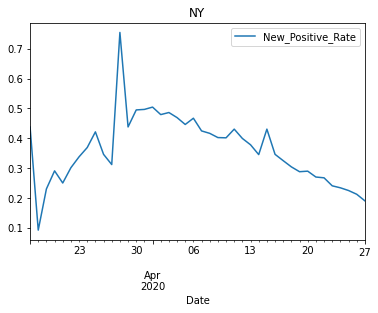

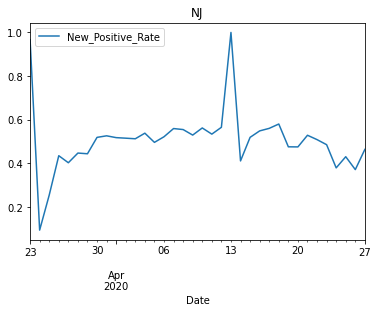

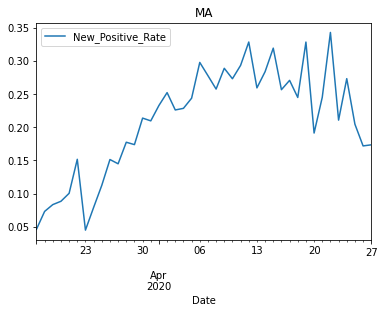

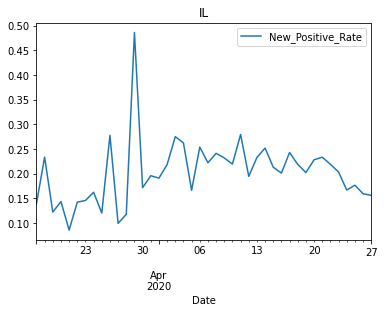

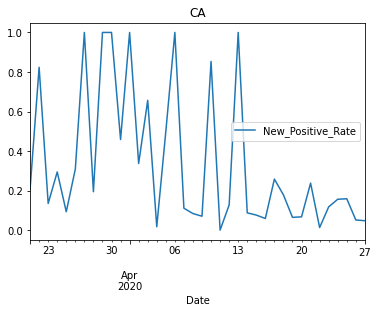

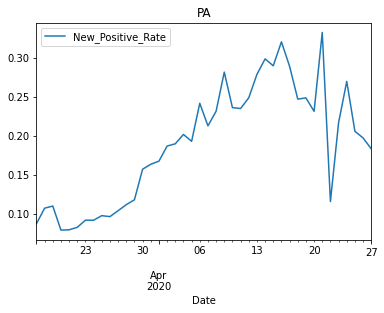

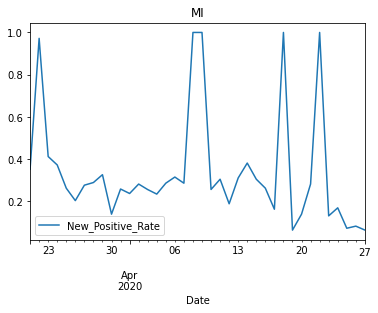

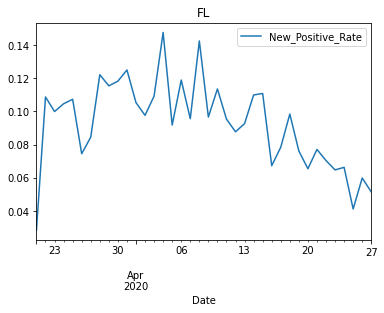

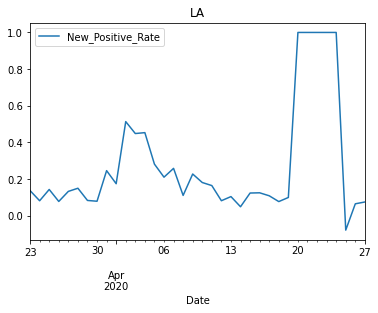

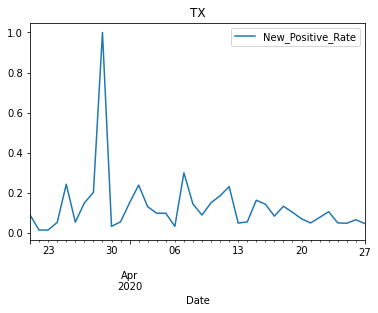

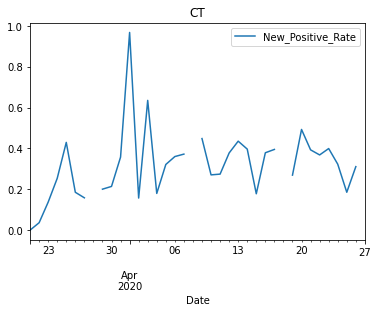

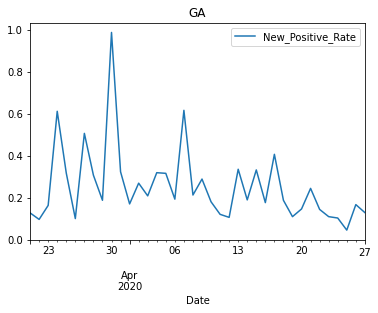

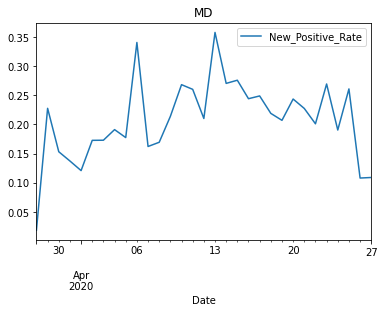

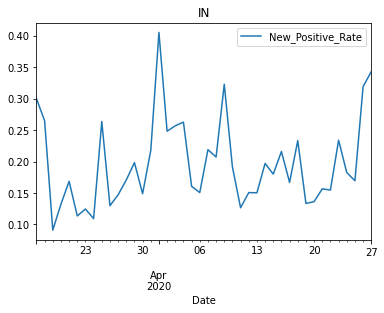

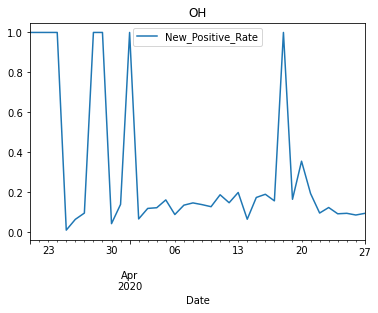

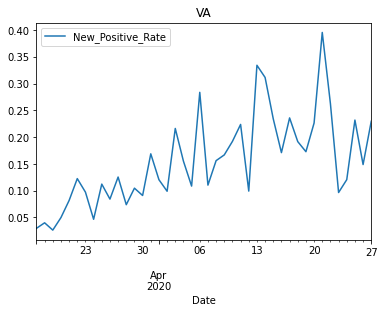

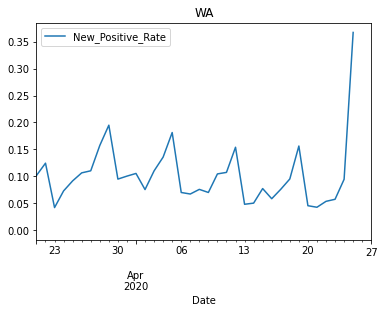

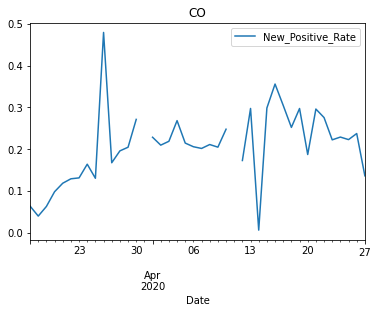

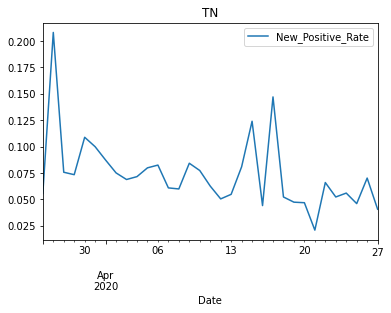

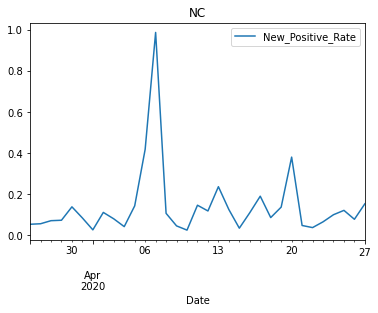

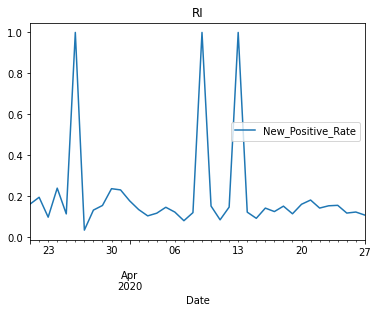

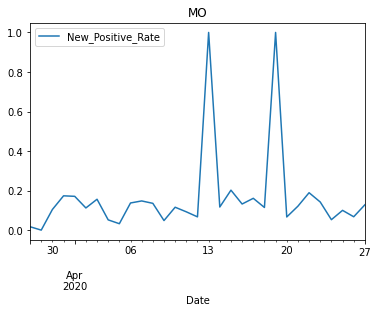

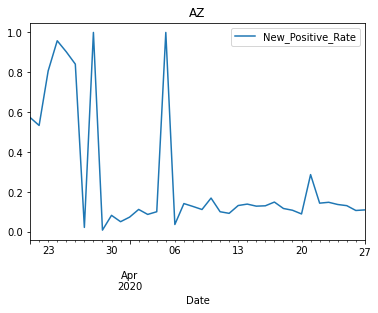

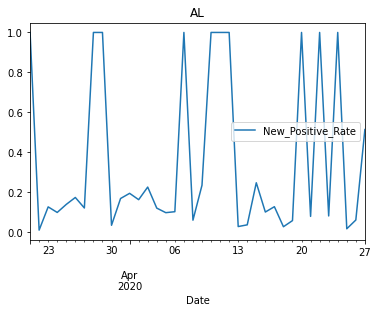

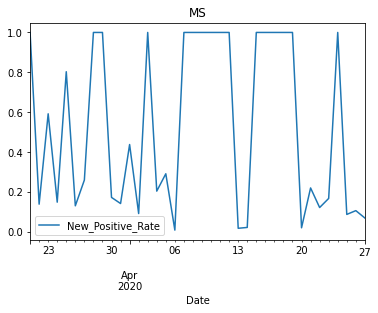

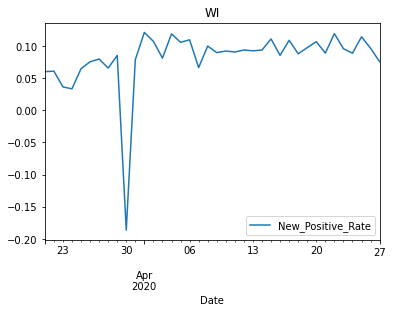

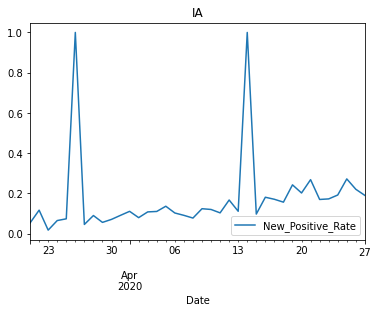

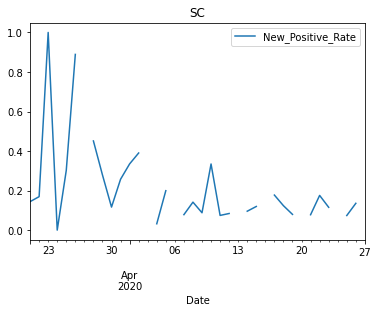

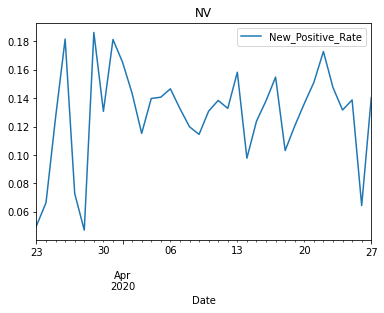

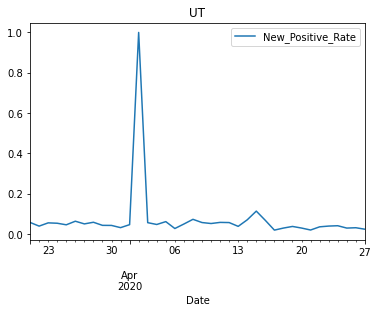

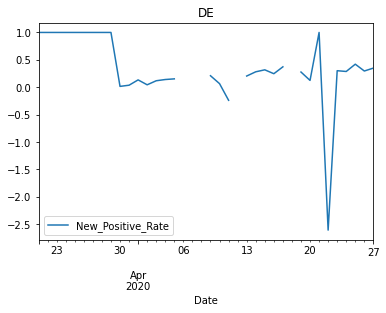

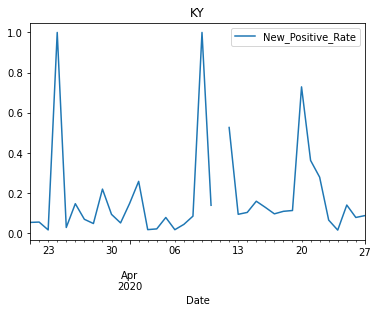

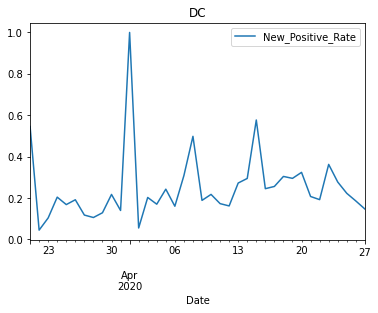

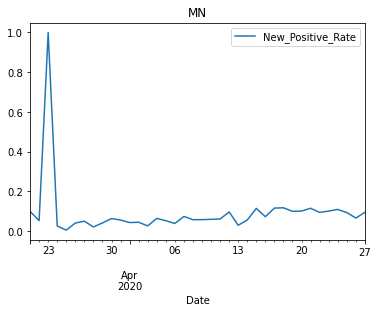

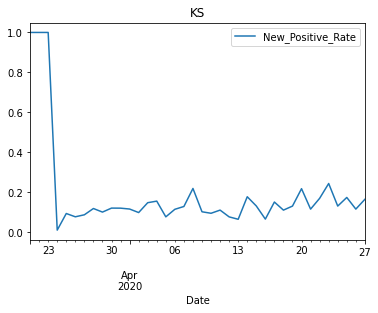

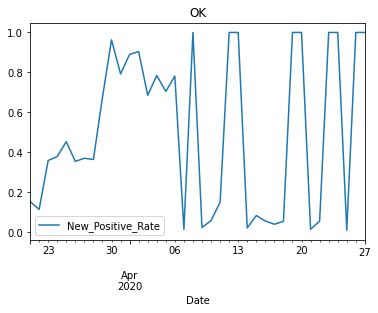

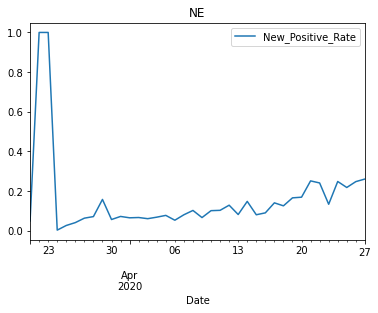

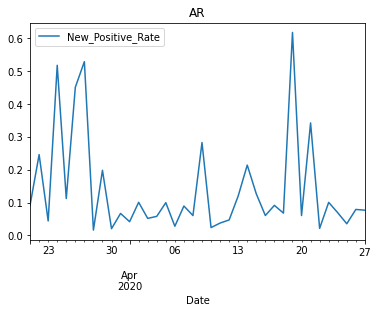

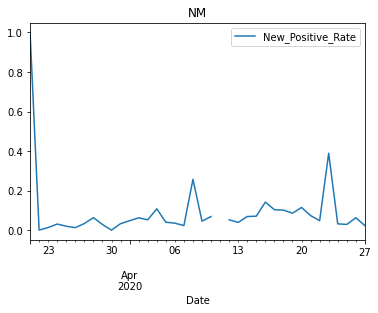

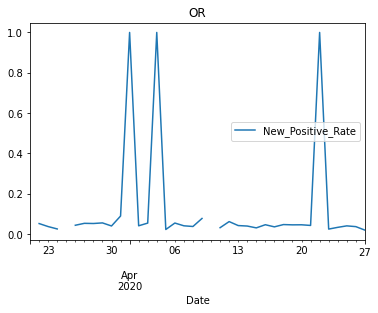

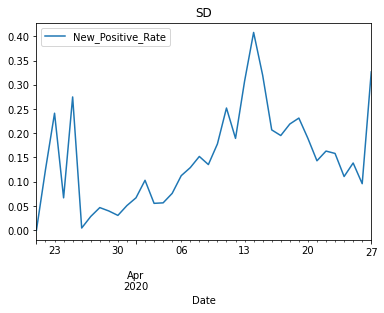

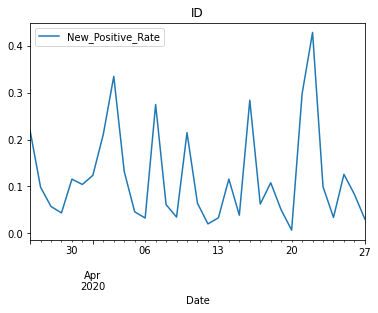

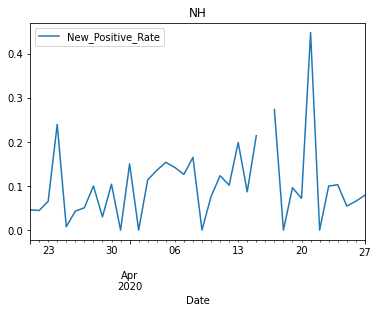

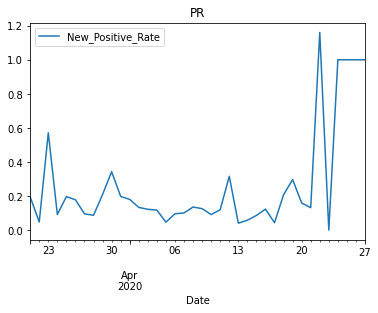

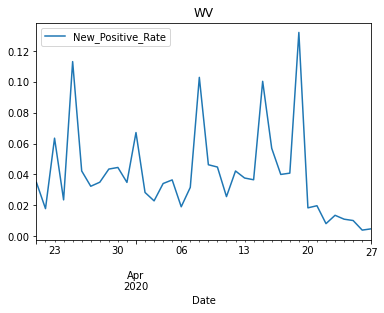

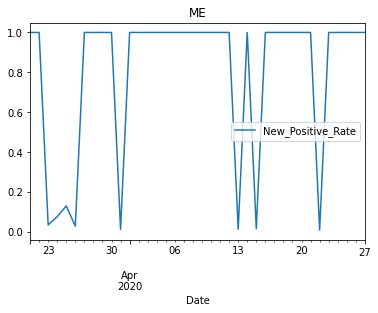

In [17]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()